In [18]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary

import matplotlib.pyplot as plt

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


In [19]:
train_ds = MNIST("E:\datasets\mnist", train=True, transform=transforms.ToTensor(), download=True)
test_ds = MNIST("E:\datasets\mnist", train=False, transform=transforms.ToTensor(), download=True)
print(f"train set: {len(train_ds)}, test set: {len(test_ds)}")

train set: 60000, test set: 10000


In [20]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [21]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, xs):
        xs = xs.view(len(xs), -1)
        xs = self.encoder(xs)
        xs = self.decoder(xs)
        xs = xs.view(len(xs), 1, 28, 28)
        return xs

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, self.latent_dim, kernel_size=7, padding=0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, 64, kernel_size=7),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Tanh()
        )

    def forward(self, xs):
        xs = self.encoder(xs)
        xs = self.decoder(xs)
        return xs

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.mean = nn.Conv2d(64, self.latent_dim, kernel_size=7, padding=0)
        self.logvar = nn.Conv2d(64, self.latent_dim, kernel_size=7, padding=0)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, 64, kernel_size=7),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Tanh()
        )
    
    def forward(self, xs):
        features = self.encoder(xs)
        mean = self.mean(features)
        logvar = self.logvar(features)
        z = self.sampling(mean, logvar)
        ys = self.decoder(z)
        return ys, mean, logvar
    
    def sampling(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + std * eps

model = VAE(12).to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 12, 1, 1]          37,644
            Conv2d-8             [-1, 12, 1, 1]          37,644
   ConvTranspose2d-9             [-1, 64, 7, 7]          37,696
             ReLU-10             [-1, 64, 7, 7]               0
  ConvTranspose2d-11           [-1, 32, 14, 14]           8,224
             ReLU-12           [-1, 32, 14, 14]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]             129
             Tanh-14            [-1, 1,

In [22]:
def train(model, xs, ys, lossfn, optim):
    model.train()
    ys_preds, mean, logvar = model(xs)
    loss, recon, kld = lossfn(ys_preds, ys, mean, logvar)

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss.item(), recon.item(), kld.item()

@torch.no_grad()
def test(model, xs, ys, lossfn):
    model.eval()
    ys_preds, mean, logvar = model(xs)
    loss, recon, kld = lossfn(ys_preds, ys, mean, logvar)

    return loss.item(), recon.item(), kld.item()

def lossfn(ys, xs, mean, logvar):
    recon = F.mse_loss(ys, xs, reduction="sum")
    kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon + kld, recon, kld

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, threshold_mode="rel", threshold=1e-3,
    patience=5, min_lr=1e-6, verbose=True)

In [23]:
import time
import numpy as np

train_losses = []
test_losses = []
for epoch in range(300):
    start = time.time()

    train_loss = []
    train_recon = []
    train_kld = []
    for xs, _ in train_dl:
        xs = xs.to(device)
        loss, recon, kld = train(model, xs, xs, lossfn, optimizer)
        train_loss.append(loss)
        train_recon.append(recon)
        train_kld.append(kld)
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)
    train_recon = np.mean(train_recon)
    train_kld = np.mean(train_kld)

    test_loss = []
    test_recon = []
    test_kld = []
    for xs, _ in test_dl:
        xs = xs.to(device)
        loss, recon, kld = test(model, xs, xs, lossfn)
        test_loss.append(loss)
        test_recon.append(recon)
        test_kld.append(kld)
    test_loss = np.mean(test_loss)
    test_losses.append(test_loss)
    test_recon = np.mean(test_recon)
    test_kld = np.mean(test_kld)

    scheduler.step(train_loss)

    consume = time.time() - start
    print(f"epoch {epoch}, consume: {consume:.1f}s ",
          f"train: loss={train_loss:.2f}, recon={train_recon:.2f}, kld={train_kld:.2f}; "
          f"test: loss={test_loss:.2f}, recon={test_recon:.2f}, kld={test_kld:.2f}"
    )

epoch 0, consume: 3.7s  train: loss=13032.92, recon=11560.78, kld=1472.14; test: loss=9440.50, recon=7025.36, kld=2415.14
epoch 1, consume: 3.8s  train: loss=9010.31, recon=6478.13, kld=2532.18; test: loss=8379.47, recon=5650.26, kld=2729.21
epoch 2, consume: 4.0s  train: loss=8457.57, recon=5720.72, kld=2736.85; test: loss=8117.28, recon=5317.23, kld=2800.04
epoch 3, consume: 3.9s  train: loss=8243.91, recon=5421.26, kld=2822.66; test: loss=7935.73, recon=5067.75, kld=2867.97
epoch 4, consume: 3.8s  train: loss=8121.13, recon=5239.87, kld=2881.27; test: loss=7885.18, recon=5259.89, kld=2625.29
epoch 5, consume: 3.7s  train: loss=8038.15, recon=5122.73, kld=2915.42; test: loss=7791.97, recon=5034.43, kld=2757.54
epoch 6, consume: 3.7s  train: loss=7964.54, recon=5031.97, kld=2932.57; test: loss=7753.19, recon=4798.97, kld=2954.22
epoch 7, consume: 3.6s  train: loss=7923.28, recon=4965.42, kld=2957.86; test: loss=7665.32, recon=4771.76, kld=2893.55
epoch 8, consume: 3.4s  train: loss=78

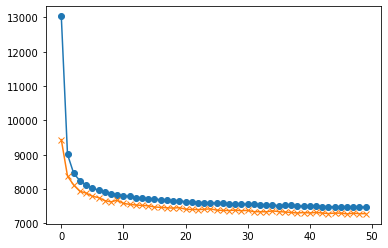

In [24]:
plt.plot(train_losses, marker='o')
plt.plot(test_losses, marker='x')

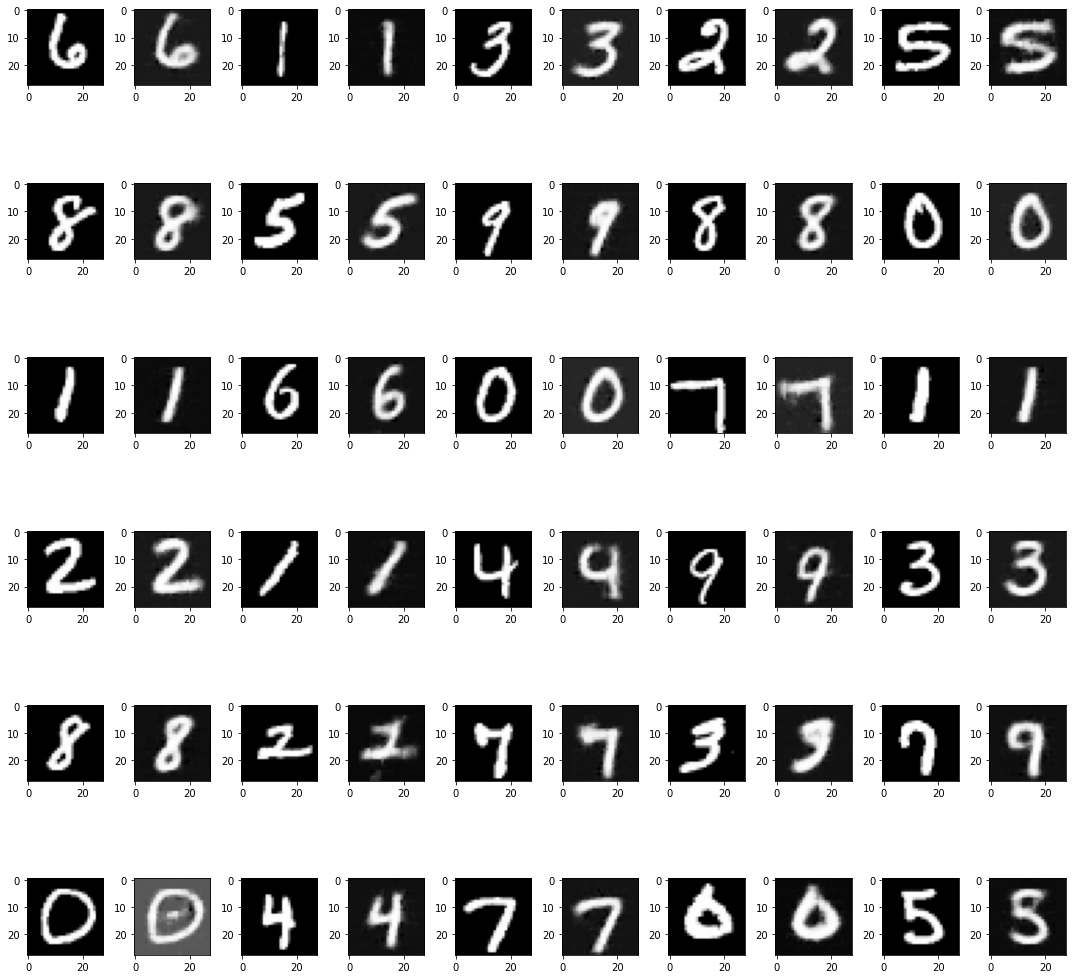

In [25]:
model.eval()
row, col = 6, 10
num_imgs = row * col // 2
fig, axes = plt.subplots(row, col, figsize=(15,15))
axes = list(axes.flatten())

for i in range(num_imgs):
    ix = np.random.randint(0, len(test_ds))
    image, _ = test_ds[ix]
    with torch.no_grad():
        pred, mean, logvar = model(image.to(device).unsqueeze(0))
        pred = pred.cpu()
        pred = pred[0]
    axes[i*2].imshow(image.permute(1, 2, 0), cmap='Greys_r')
    axes[i*2+1].imshow(pred.permute(1, 2, 0), cmap='Greys_r')
plt.tight_layout()
plt.show()

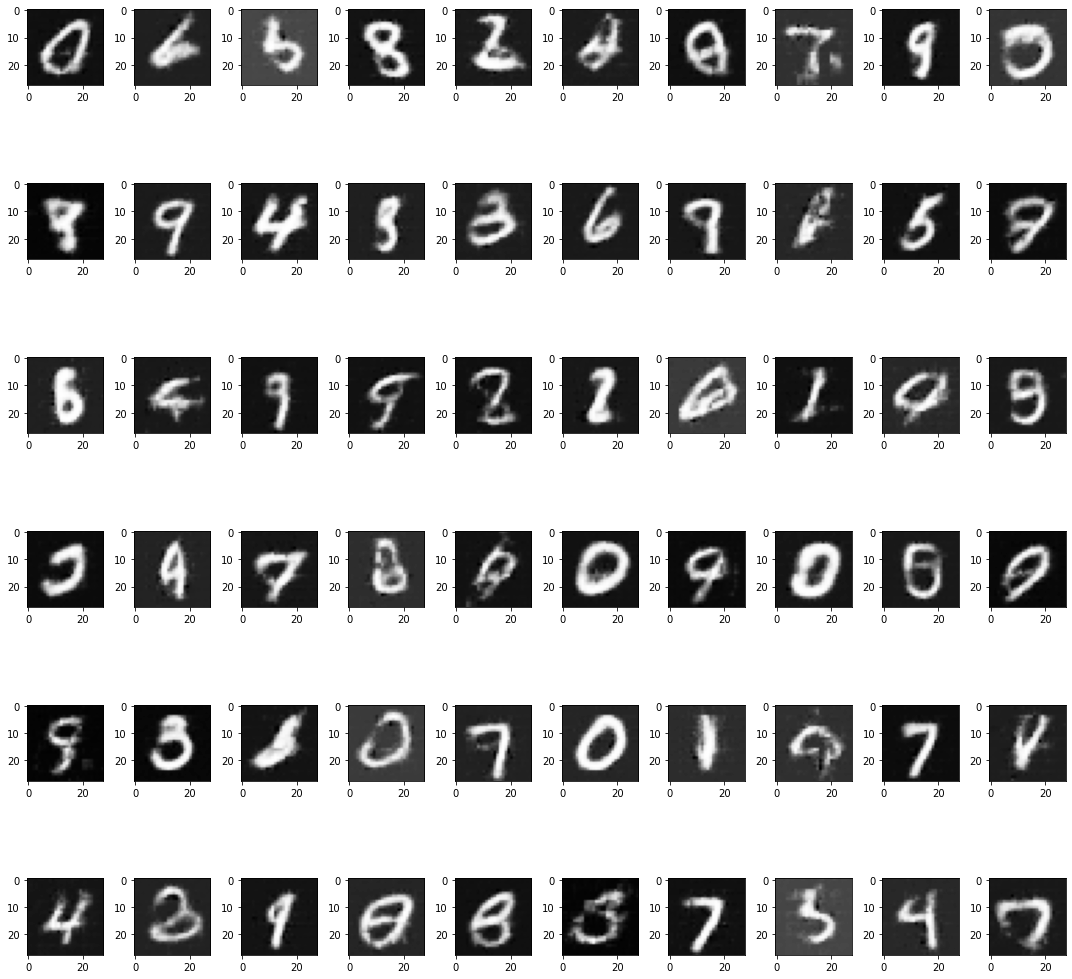

In [26]:
model.eval()
row, col = 6, 10
fig, axes = plt.subplots(row, col, figsize=(15,15))
axes = list(axes.flatten())

for i in range(len(axes)):
    z = torch.randn([1, 12, 1, 1]).to(device)
    with torch.no_grad():
        pred = model.decoder(z)
        pred = pred.cpu()
        pred = pred[0]
    axes[i].imshow(pred.permute(1, 2, 0), cmap='Greys_r')
plt.tight_layout()
plt.show()

C:\Users\liang\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\liang\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


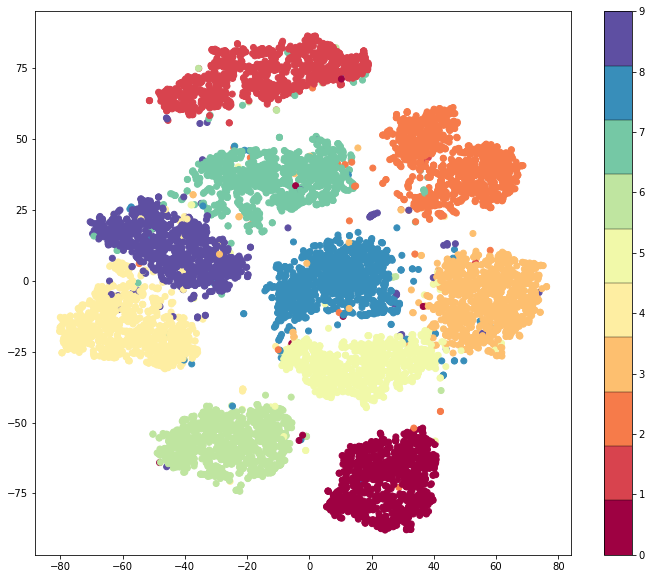

In [27]:
from sklearn.manifold import TSNE

latent_vectors = []
classes = []

for img, y in test_dl:
    classes.extend(y)
    latent = model.encoder(img.to(device)).cpu()
    latent = latent.view(len(latent), -1)
    latent_vectors.append(latent)

latent_vectors = torch.cat(latent_vectors).detach().numpy()
tsne = TSNE(2)
clustered = tsne.fit_transform(latent_vectors)
fig = plt.figure(figsize=(12, 10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

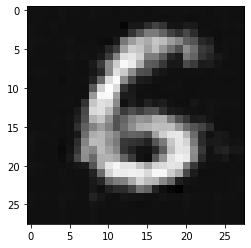

In [28]:
a = torch.rand(1, 12, 1, 1).to(device)
img = model.decoder(a)[0].cpu().detach()
plt.imshow(img.permute(1, 2, 0), cmap="Greys_r")